# 2023年度报告-净资产收益率

使用em的业绩报告数据。

In [1]:
import pandas as pd
from scipy.stats import zscore
import akshare as ak
from jinja2 import Environment, FileSystemLoader
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
# import altair as alt
import numpy as np
from IPython.display import HTML
import sqlite3
from pathlib import Path
import datetime
from uuid import uuid4


In [2]:
# 解决matplotlib的中文问题
# bash中使用fc-list 找到family name
# plt.rcdefaults() # 样式调乱了，需要用它重置一下。
font_path = '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'
fm.fontManager.addfont(font_path)
# 设置全局字体为
matplotlib.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.style.use('ggplot')

In [3]:
# def begin with plot, always use widedf
# def begin with draw, always use other df

def showProfile(df) :
    col_profile = pd.concat([df.dtypes, df.isna().sum()/len(df)*100, df.sample().T], axis=1 ).reset_index()
    col_profile.columns = ['列名', '类型', '缺失比%','样例']
    return (col_profile)

def plot_barh(df, title=None, fmt=''):
    """
    plot barh, x axis on top. If title not set, use df.columns[0] as title.
    """
    height = len(df)*25/72+0.5
    ax = df.plot.barh(figsize=(10, height), width=0.8, legend=False, zorder=3)
    ax.bar_label(ax.containers[0], label_type='edge', fmt=fmt)
    ax.xaxis.tick_top()
    title = title if title else df.columns[0]
    ax.set_title(title, fontsize=16, pad=20)
    
    plt.show(ax)

def df_cards(df, cols=None):
    """
    把df的每一行转化为html卡片形式。
    df: 整理好的DataFrame
    cols: 要展示的列名列表，需要在调用前进行修改。确定需要展示的样式：title, big, item, content等， 如果不提供，默认使用df的列名。
    """
    if not cols:
        cols = df.columns
    df.columns = [i for i in range(len(df.columns))]
    env = Environment(loader=FileSystemLoader('.'))
    template = env.get_template('cards.html')
    html_out = template.render(cols=cols, df=df)

    return HTML(html_out)

def plot_desc(df:pd.DataFrame):
    """
    x is time axis
    """
    df = df.T
    df = pd.concat([df.mean(), df.median(), df.max(), df.min()], axis=1)
    df.columns = ['mean', 'median', 'max', 'min']
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    df.iloc[:,[0,1]].plot(kind='line', ax=axs[0])
    df.iloc[:,[2,3]].plot(kind='line', ax=axs[1])
    plt.tight_layout()
    plt.show()

def plot_labs(df: pd.DataFrame, oneline:bool = False):
    """
    将df输出为包含三个值title, value, rank的标签。
    df: 二列或者三列，第一列为cname, 第二列为值，第三列可为其它数，如果没有第三列，则创建第三列为rank
    """
    uid = uuid4()
    if len(df.columns) == 2:
        df = df.reset_index(drop=True)
        df['rank'] = df.index+1
    codes = pd.read_csv('codes.csv', dtype={'code':'str'})[['cname', 'code']]
    df = df.merge(codes, on='cname')
    env = Environment(loader=FileSystemLoader('.'))
    template = env.get_template('lab.html')
    html_out = template.render(df=df, oneline = oneline, uid = uid)
    return HTML(html_out)

def plot_subs(df:pd.DataFrame, cols:int, kind:str = 'barh', sharex:bool = True, sharey:bool = True):
    """
    plot subplot.
    df: must be tidied, keep only data cols
    cols: how many columns in the subplots
    """
    s = df.shape
    rows = int(s[1]/cols)+1
    lay = (rows, cols)
    height = s[0]*0.3*rows
    axs = df.plot(kind=kind, subplots=True, layout=lay, figsize=(10,height), sharex=sharex, sharey=True, fontsize=8, legend=False)
    plt.tight_layout()  # 调整子图布局，避免重叠
    plt.show()

def plot_muti_lines(df: pd.DataFrame):
    """
    multiline chart
    legend order by last column, and in left side.
    """
    height = max(0.3*len(df.T), 5)
    ax = df.plot.line(figsize=(10, height))
    handles, labels = ax.get_legend_handles_labels()
    # h = list(df.iloc[-1].sort_values(ascending=False).index.values)
    ol = list(df.iloc[-1].sort_values(ascending=False).index.values)
    oh = [handles[labels.index(label)] for label in ol]
    ax.legend(oh, ol, loc='upper left')
    plt.show(ax)

def plot_cdf(df:pd.DataFrame, col:int = -1, logx : bool = False):
    x = df.iloc[col, :].sort_values()
    y = np.linspace(0, 1, len(x))
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(x, y)
    if logx:
        ax.set_xscale('log')  # 设置 x 轴为对数轴
    ax.twinx().set_ylim(0, len(x))

    plt.show()

def plot_total_change(df:pd.DataFrame):
    """
    df: index is year, columns is cname.
    return barh with 2 axes.
    share y axis which is year.
    x axis is total, pct change.
    """
    height = 0.3*len(df)+1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, height), sharey=True)
    df.T.sum().plot.barh(ax=ax1, width=0.8, title='Total')
    df.T.sum().pct_change().plot.barh(width=0.8, title = 'Pct Change')
    ax2.bar_label(ax2.containers[0], fmt='{:.2%}')
    plt.tight_layout()
    plt.show()

def draw_vhists(df:pd.DataFrame, bins:int = 14, fig_cols:int =3):
    """
    df: must be tidied, keep only numeric data cols only.
    fig_cols: how many columns in the subplots
    """
    def divide_or_ceil(a:int, b:int):
        if a % b == 0:
            return a // b
        else:
            return (a // b) + 1
    df_cols = len(df.columns)
    rows = divide_or_ceil(df_cols, fig_cols)
    height = 0.3*bins*rows+1
    fig, axs = plt.subplots(rows, fig_cols, figsize=(10,height))
    axs = axs.flatten()
    for i in range(df_cols):
        axs[i].hist(df.iloc[:,i], bins=bins, edgecolor='white', linewidth=1.2, orientation='horizontal')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()  # 调整子图布局，避免重叠
    plt.show()

def cross_dfs(df:pd.DataFrame, to_cross:list):
    """
    求出若干个df的交集，每个df都有cname列。
    """
    res = set(df['cname'])
    for d in to_cross:
        res &= set(d['cname'])
    ret_df = df[df['cname'].isin(res)]
    return ret_df

def de_banks(df:pd.DataFrame):
    ret = df[~df['cname'].str.contains(r'银行|商行|证券')]
    print(f'total: {len(df)} | banks: {len(df)-len(ret)} | non-banks: {len(ret)}')
    return ret

def fold_a_col(s:pd.Series, n:int = 10, fmt = '{:.2f}'):
    """
    fold a column into n columns
    input series must be indexed by cname, and values are numbers
    output: cname + value in every cell
    """
    df = s.dropna().sort_values(ascending=False).to_frame()
    df['cname'] = df.index + ' ' + df.iloc[:,-1].map(lambda x: fmt.format(x))
    df['group'] = [i % n for i in range(len(df))]
    folded = pd.concat([g.reset_index(drop=True)[['cname']] for _, g in df.groupby('group')], axis=1)
    folded.columns = [i+1 for i in range(n)]
    print(f'total: {len(df)}')
    return folded.style


In [4]:
class YJBB:
    ALL_COLS = ['序号', '股票代码', '股票简称', '每股收益', '营业收入-营业收入', '营业收入-同比增长', '营业收入-季度环比增长', '净利润-净利润', '净利润-同比增长', '净利润-季度环比增长', '每股净资产', '净资产收益率', '每股经营现金流量', '销售毛利率', '所处行业', '最新公告日期']
    
    def __init__(self, q:str = '1231'):
        self.df = self.get_data(q)
        self.indu_dict = self.df.groupby('cname')['industry'].first().to_dict()
        self.codedf = self.get_codes()
        self.code_dict = self.get_code_dict()

    def get_data(self, q:str = '1231'):
        cols = ['股票代码', '股票简称', '每股收益', '营业收入-营业收入','净利润-净利润', '每股净资产', '净资产收益率', '每股经营现金流量', '所处行业', 'rdate']
        cols_str = ', '.join([f'"{col}"' if '-' in col else col for col in cols])
        conn = sqlite3.connect('../yjbb.db')
        df = pd.read_sql_query(f'select {cols_str} from yjbb_data where substr(rdate, -4) = "{q}"', conn)
        conn.close()
        df.columns = ['code', 'cname', 'eps', 'revenue', 'profit', 'bvps', 'roe', 'ocf', 'industry', 'rdate']
        qs = {'1231': 'Q4', '0331': 'Q1', '0630': 'Q2', '0930': 'Q3'}
        df['rdate'] = df['rdate'].str[2:4]+qs[q]
        df.replace(0, np.nan, inplace=True)
        return df
    
    def get_codes(self):
        current_time = datetime.datetime.now().timestamp()
        codes = Path('codes.csv')
        if codes.exists() :
            diff = current_time - codes.stat().st_mtime
            if diff < 3600*24:
                df = pd.read_csv(codes, dtype={'code': str})
                return df

        df = ak.stock_zh_a_spot_em()[['代码', '名称','市盈率-动态', '市净率', '总市值']]
        df.columns = ['code', 'cname', 'pe', 'pb', 'mv']
        df.to_csv(codes, index=False)
        return df
    
    def get_code_dict(self):
        codes = self.codedf
        codes['link'] = codes['code'] + codes['cname']
        codes['link'] = codes['link'].apply(lambda x: f'<a href="https://data.eastmoney.com/stockdata/{x[0:6]}.html" target="_blank">{x[6:]}</a>')
        code_dict = codes.set_index('cname')['link'].to_dict()
        return code_dict
        
    def wide_df(self, df:pd.DataFrame, df_col: str):
        """
        去除新三板的数据，去除报告有异常空值的数据。
        返回整理好的数据。行为期数，列为股票代码，值为数据。
        """
        # df = self.df if not df else df
        tdf = df.pivot_table(index='rdate', columns='cname', values=df_col, aggfunc='first')
        a_code = self.codedf['cname']
        use_code = list(set(tdf.columns) & set(a_code))
        # 去除中间有空值的代码
        tdf = tdf[use_code]
        rdate_idx = tdf.index
        tdf = tdf.reset_index(drop=True)
        first_nonull_index = list(tdf.apply(lambda col: col.first_valid_index()))
        null_counts = tdf.isnull().sum().to_list()
        mask = [False if null_counts[i] > first_nonull_index[i] else True for i in range(len(null_counts))]
        widedf = tdf[tdf.columns[mask]]
        widedf.index = rdate_idx
        # longdf = widedf.reset_index().melt(id_vars='rdate', var_name='code', value_name=df_col).dropna()
        return widedf
    
    def get_mostn(self, df:pd.DataFrame, n:int=300, ascending:bool = False):
        """
        input df: widedf, index by year.
        return df: any cname appeared in top n in any year.
        num: how many times appeared.
        tnum: total reports.
        pct: hit times of total reports.
        """
        mostn_per_year = df.T.apply(lambda x: x.sort_values(ascending=ascending).head(n).index)
        mostn_all = mostn_per_year.melt()['value'].value_counts().to_frame('hits')
        total_reports = df.count().to_frame('total')
        mostn_all = mostn_all.merge(total_reports, left_index=True, right_index=True)
        mostn_all['pct'] = mostn_all['hits'] / mostn_all['total']
        mostn_all = mostn_all.sort_values(by='pct', ascending=ascending)

        return (mostn_per_year.map(lambda x: self.code_dict[x]).style, mostn_all)

    def incr_ana(self, df:pd.DataFrame) -> pd.DataFrame:
        mask = (df <= 0).any().values
        no_neg_df = df.iloc[:,~mask]
        neg_df = df.iloc[:,mask]
        card = {
            '从未亏损':len(no_neg_df),
            '有过亏损':len(neg_df)
        }
        most_loss = neg_df.min(axis=1)
        # 亏损次数排序
        loss_by_count = ((neg_df <= 0).sum() / neg_df.count()).sort_values()
        # 亏损金额占盈利金额排序
        loss_by_value = (neg_df[neg_df <= 0].sum() / neg_df[neg_df > 0].sum()).sort_values() 

        # 观察从没有亏损过的公司，因为负数无法使用对数增长率。
        log_inc = np.log(no_neg_df).diff()
        l = len(log_inc)
        ret_df = pd.concat([log_inc.count(), log_inc.mean(), log_inc.median(), log_inc.sum()], axis=1)
        ret_df.columns = ['count', 'mean', 'median', 'sum']
        # keep rows more than 6 years
        ret_df = ret_df[ret_df['count'] >6]
        # 总增长幅度
        ret_df['total'] = log_inc.sum()
        # 正增长次数
        ret_df['posi_count'] = ((log_inc > 0).sum() / log_inc.count())
        # 夏普指数
        ret_df['sharpe'] = ret_df['mean'] / log_inc.std()
        # 夏普指数近五年滚动值平均
        ss = [log_inc.iloc[:l-i,:].mean() / log_inc.iloc[: l-i, :].std() for i in range(5)]
        ret_df['sharpe_r5'] = (pd.concat(ss, axis=1).T.mean()).apply(lambda x : round(x, 2))
        sharpe_df = ret_df.sort_values('sharpe_r5', ascending=False)

        return (log_inc, sharpe_df)
    
    def neg_ana(self, df:pd.DataFrame) -> pd.DataFrame:
        df =df.T
        ret = pd.concat(
            [(df <= 0).sum()
            , df.count()
            , df[df <= 0].sum()
            , df.sum()],
            axis=1)
        ret.columns = ['neg_count', 'total_count', 'neg_value', 'total_value']
        ret['c_pct'] = ret['neg_count'] / ret['total_count']
        ret['v_pct'] = ret['neg_value'] / (ret['neg_value']-ret['total_value'])
        return ret  
    
    def mostn_by_func(self, df:pd.DataFrame, mostn:int = 300, ascending:bool = False, no_sum:bool = False):
        # for func in ['sum', 'mean', 'median', 'min', 'max']:
        funcs = ['mean', 'median', 'min', 'max'] if no_sum else ['sum', 'mean', 'median', 'min', 'max']
        res = [ df.agg(func).sort_values(ascending=ascending).to_frame(func).head(mostn).index.values for func in funcs]
        ret = pd.DataFrame(res).T
        ret.columns = funcs
        ret = ret.map(lambda x: self.code_dict[x]).style
        return ret
    
    def gt_all_years(sefl, df:pd.DataFrame, low:int = 10, high:int = 16):
        """
        find all companies that have been greater than n in all years
        """
        res = pd.DataFrame({
            n: (df > n).sum() for n in range(low, high)
        })
        total_s = df.count()
        res = res[res.apply(lambda x : x == total_s)]
        cols = [f'{v} gt {k}' for k, v in res.count().items()]
        res.columns = cols
        res.index = res.index.map(lambda x: yjbb.code_dict[x])
        res = res.sort_values(by=cols[0], ascending=False)
        return res
    
    def gt_per_year(self, df:pd.DataFrame, n:int = 15):
        """
        plot barh of count of companies that have been greater than n in each year
        """
        s = (df > n).sum(axis=1)
        total = df.count(axis=1)
        res = s.to_frame(f'count great than {n}')
        res['pct'] = res[f'count great than {n}'] / total
        plot_subs(res,2, sharex=False)

    def fold_a_col(self, s:pd.Series, n:int = 10, fmt = '{:.2f}'):
        """
        fold a column into n columns
        input series must be indexed by cname, and values are numbers
        output: cname + value in every cell
        """
        df = s.dropna().sort_values(ascending=False).to_frame()
        df['cname'] = df.index.map(lambda x: self.code_dict[x]) + ' ' + df.iloc[:,-1].map(lambda x: fmt.format(x))
        df['group'] = [i % n for i in range(len(df))]
        folded = pd.concat([g.reset_index(drop=True)[['cname']] for _, g in df.groupby('group')], axis=1)
        folded.columns = [i+1 for i in range(n)]
        print(f'total: {len(df)}')
        return folded.style
    
    def indu_count(self, s:pd.Series, n:int = 20):
        indu = s.map(lambda x: self.indu_dict[x])
        indu_count = indu.value_counts().sort_values(ascending=True)
        print(f'total: {len(indu_count)} | top {n} : {indu_count.tail(n).sum() / indu_count.sum() * 100:.2f}%')
        plot_barh(indu_count.tail(n).to_frame('count'))


yjbb = YJBB('1231')

In [5]:
roe_df = yjbb.wide_df(yjbb.df, df_col='roe')

## 净资产收益率

### 全市场ROE

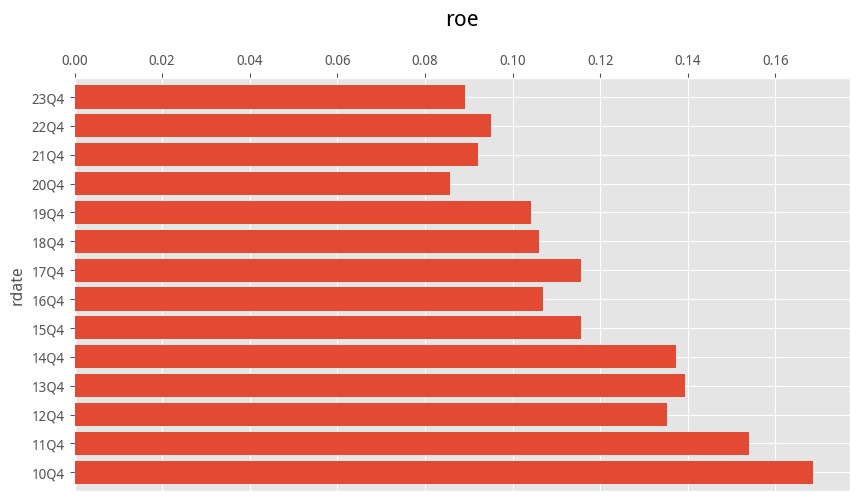

In [6]:
long_df = yjbb.df[['code', 'cname', 'rdate', 'roe', 'profit']].copy()
long_df['asset'] = long_df['profit'] / long_df['roe'] * 100
long_df.dropna(inplace=True)
asset_df = yjbb.wide_df(long_df, df_col='asset')
profit_df = yjbb.wide_df(long_df, df_col='profit')
total_asset_per_year = asset_df.sum(axis=1)
total_profit_per_year = profit_df.sum(axis=1)
roe_per_year = total_profit_per_year / total_asset_per_year
plot_barh(roe_per_year.to_frame('roe'))

- ROE总体是下降的，2020年疫情开始急剧下降，但后两年有所回升，但2023年明显下降。

### ROE排名前20

In [7]:
yjbb.mostn_by_func(roe_df, 20, ascending=False, no_sum=True)

,mean,median,min,max
0,三一重能,键邦股份,艾罗能源,骏创科技
1,骏创科技,敷尔佳,德业股份,卓锦股份
2,艾罗能源,星宸科技,联域股份,三一重能
3,敷尔佳,蕾奥规划,公牛集团,中英科技
4,中英科技,艾罗能源,亿联网络,海南机场
5,纳睿雷达,贝泰妮,北自科技,若羽臣
6,曼恩斯特,曼恩斯特,绿联科技,致远新能
7,致远新能,思泰克,武汉蓝电,光库科技
8,卓兆点胶,公牛集团,贵州茅台,九丰能源
9,小熊电器,博硕科技,宝立食品,纳睿雷达


- ROE高的公司，看来都不是大公司。茅台是个例外。

### 总体变化

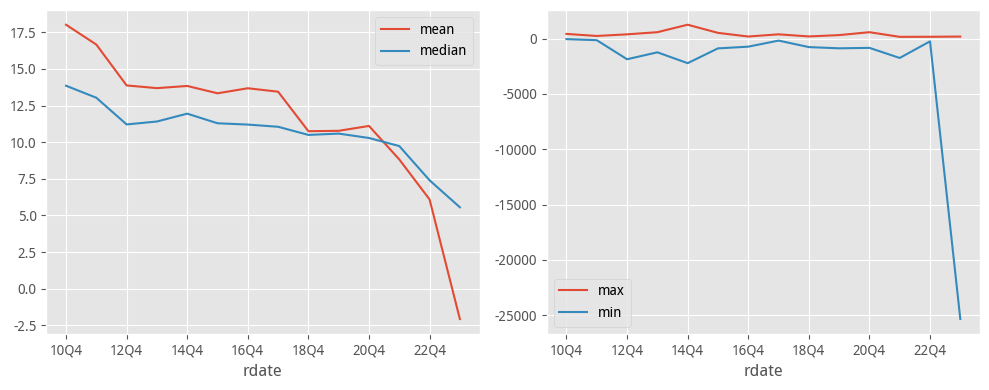

In [8]:
plot_desc(roe_df)

- ROE的均值和中位数都在下降。而且下降的幅度很大。
- 均值已经降到0以下了，中位数还能保持在5%以上。
- 2022和2023年出现了极大的亏损。

### 每年前20

In [9]:
top20 = yjbb.get_mostn(roe_df, 20, ascending=False)
top20[0]

rdate,10Q4,11Q4,12Q4,13Q4,14Q4,15Q4,16Q4,17Q4,18Q4,19Q4,20Q4,21Q4,22Q4,23Q4
0,海南机场,冰川网络,光库科技,卓锦股份,骏创科技,中英科技,南新制药,致远新能,敷尔佳,纳睿雷达,三一重能,宏达股份,艾罗能源,华控赛格
1,海信家电,电魂网络,明德生物,观想科技,若羽臣,九丰能源,仙乐健康,光峰科技,昱能科技,概伦电子,宁波东力,热景生物,九安医疗,石英股份
2,航锦科技,峆一药业,电魂网络,天永智能,中再资环,小熊电器,泰鹏智能,国能日新,科瑞思,中科蓝讯,金迪克,湖北宜化,融捷股份,中基健康
3,中航产融,京基智农,全志科技,西藏珠峰,思泉新材,赛维时代,锦好医疗,四川金顶,多瑞医药,航天软件,卓兆点胶,东方生物,天华新能,澳洋健康
4,利君股份,天润科技,浩物股份,博睿数据,喜悦智行,安克创新,中胤时尚,康华生物,曼恩斯特,曼恩斯特,中红医疗,中远海控,明德生物,银宝山新
5,金杯汽车,丸美股份,鑫汇科,电魂网络,赛腾股份,沪光股份,迎丰股份,博硕科技,盛美上海,灿勤科技,獐子岛,重庆啤酒,天齐锂业,重庆啤酒
6,神州数码,盛和资源,艾德生物,川恒股份,天阳科技,品渥食品,小熊电器,美畅股份,万邦医药,美腾科技,义翘神州,倍益康,仁智股份,顾地科技
7,福斯特,蓝思科技,汇顶科技,明德生物,英搏尔,美登科技,蕾奥规划,东芯股份,清研环境,敷尔佳,ST升达,中微半导,安旭生物,艾罗能源
8,海思科,晨曦航空,ST联络,华夏航空,值得买,善水科技,新赣江,新赣江,丛麟科技,微导纳米,博拓生物,华洋赛车,江特电机,TCL智家
9,慈星股份,南大光电,京能热力,基蛋生物,奥特维,三态股份,安克创新,昀冢科技,昀冢科技,准油股份,威力传动,麦加芯彩,永兴材料,京基智农


- ROE排前列的总体比较分散，医疗器械和互联网服务上榜的次数比较多。
- 几乎每年的前20都不相同，很少有企业能在这个榜上连续多年上榜。

total: 62 | top 20 : 66.95%


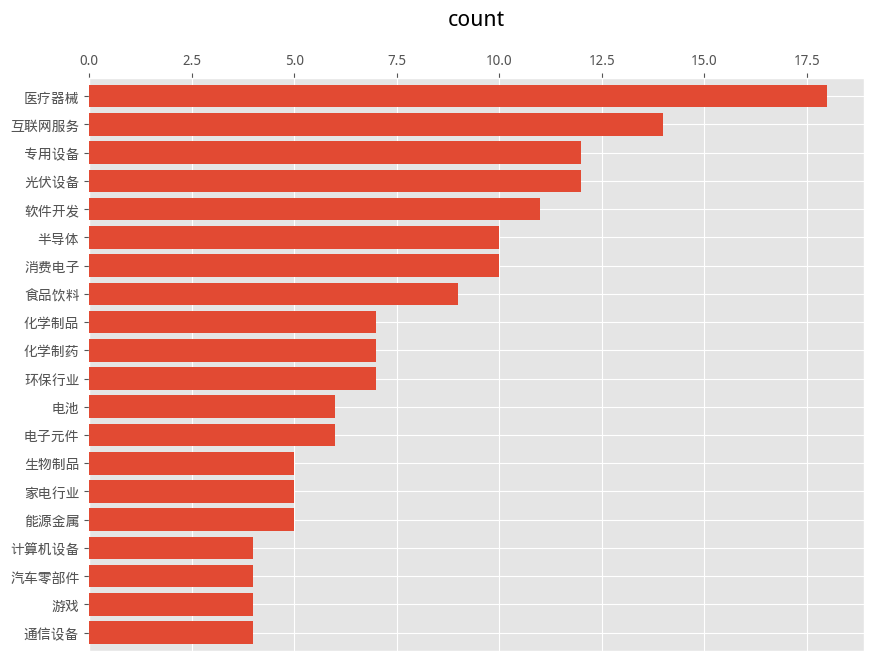

In [10]:
yjbb.indu_count(top20[1].index)

### 最近一年分布

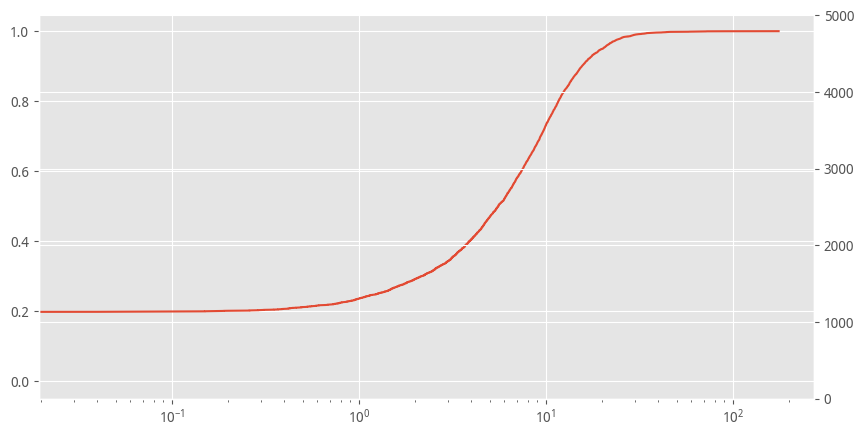

In [11]:
plot_cdf(roe_df, logx=True)

- 大约70%的公司ROE在10%以以下。

## TOP300

In [12]:
top300 = yjbb.get_mostn(roe_df, 300)


total: 84 | top 20 : 59.27%


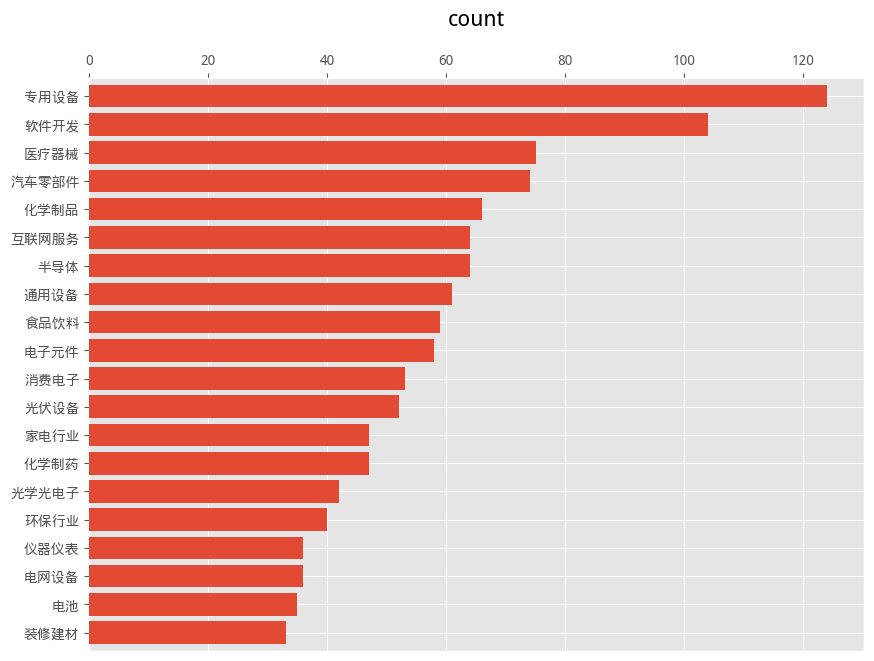

In [13]:
yjbb.indu_count(top300[1].index)

- ROE高的行业，公司普遍比较小。
- 证券和保险业的公司很少上榜，而银行业没有上过。

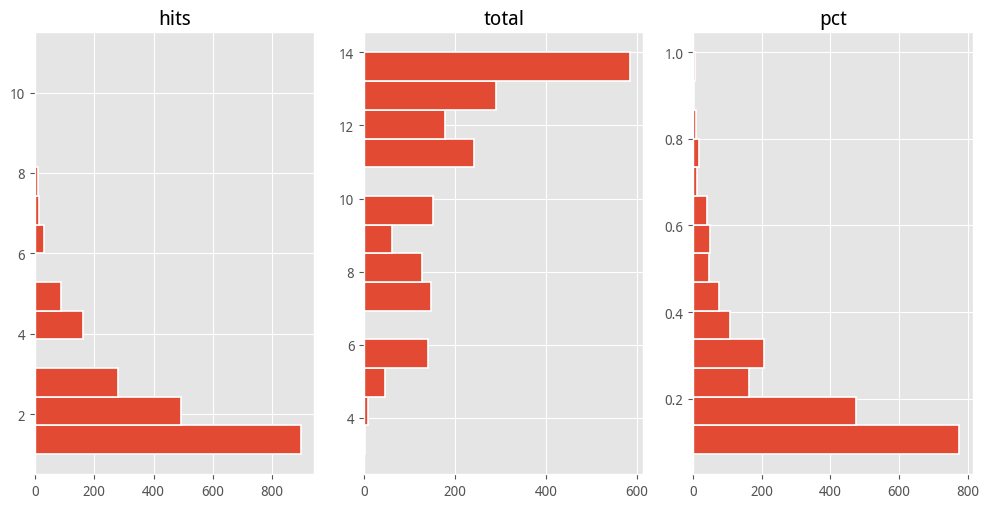

In [14]:
draw_vhists(top300[1])

- 上过榜的，还是以老公司为主。但基本上也就上过一两次。
- 保持高的ROE是不太可能的事。

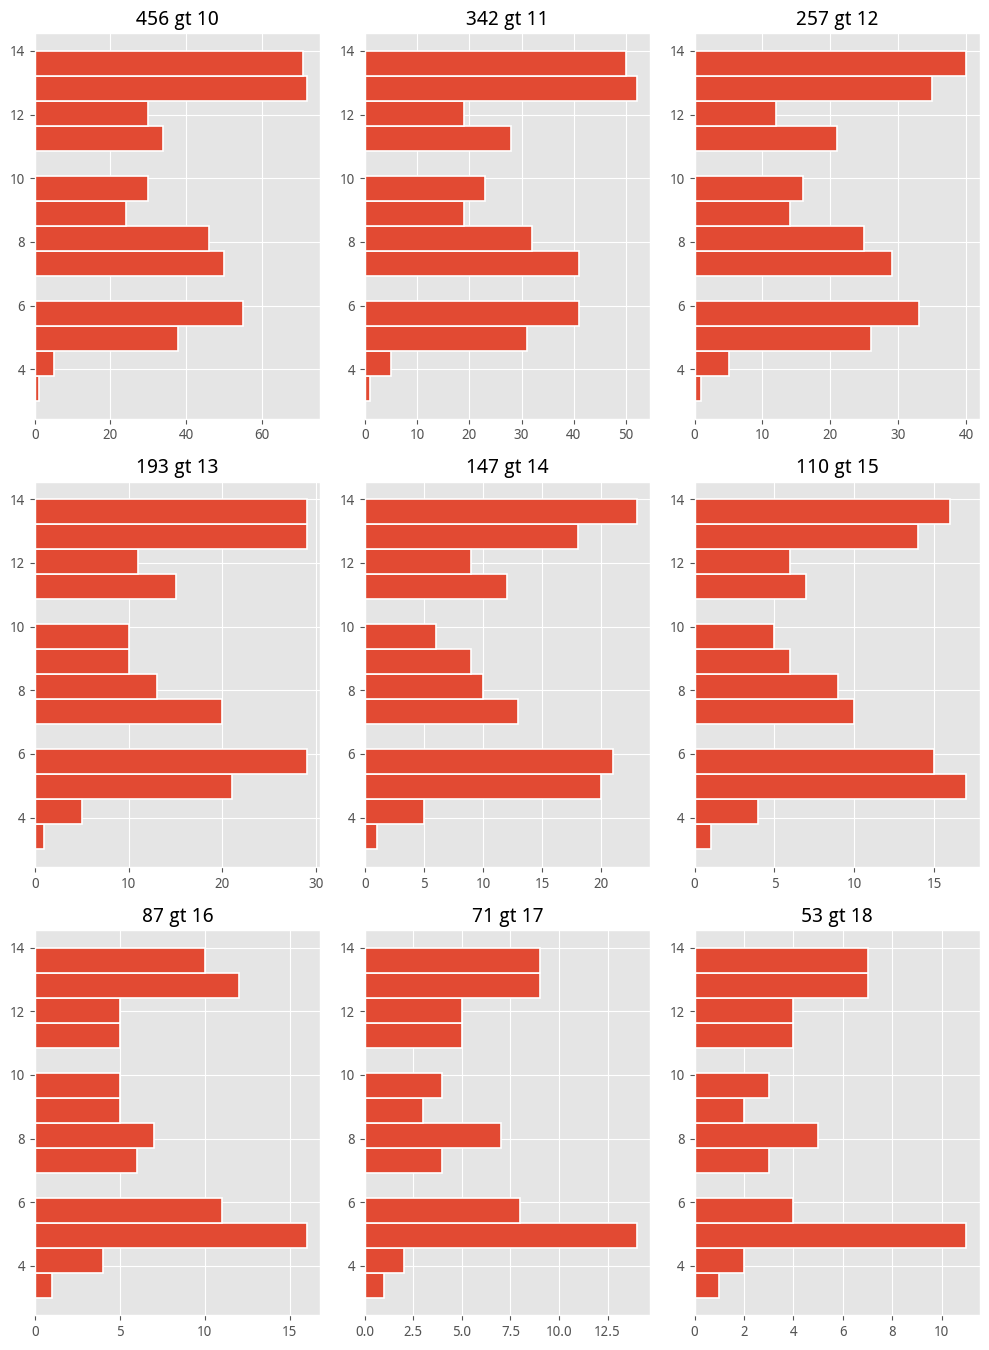

In [15]:
roe10 = yjbb.gt_all_years(roe_df, 10, 19)
draw_vhists(roe10)

### 每年ROE都超过15%的公司

In [16]:
fold_a_col(roe10.iloc[:,-4],10)

total: 110


,1,2,3,4,5,6,7,8,9,10
0,古井贡酒 14.00,格力电器 14.00,伊利股份 14.00,海尔智家 14.00,海天味业 14.00,长春高新 14.00,片仔癀 14.00,贵州茅台 14.00,招商银行 14.00,承德露露 14.00
1,宏发股份 14.00,洋河股份 14.00,法拉电子 14.00,老凤祥 14.00,恩华药业 14.00,海康威视 14.00,晨光股份 13.00,元祖股份 13.00,今世缘 13.00,新坐标 13.00
2,弘亚数控 13.00,中科软 13.00,广州酒家 13.00,飞科电器 13.00,口子窖 13.00,欧派家居 13.00,周大生 13.00,美的集团 13.00,迎驾贡酒 13.00,浙江鼎力 13.00
3,欧普康视 12.00,三人行 12.00,凌霄泵业 12.00,亿联网络 12.00,武汉蓝电 12.00,新产业 12.00,嘉友国际 11.00,珀莱雅 11.00,广咨国际 11.00,明阳科技 11.00
4,中谷物流 11.00,志邦家居 11.00,欧晶科技 11.00,爱美客 10.00,呈和科技 10.00,安克创新 10.00,思泰克 10.00,骏创科技 10.00,正海生物 9.00,工业富联 9.00
5,曙光数创 9.00,中裕科技 9.00,爱玛科技 9.00,公牛集团 9.00,国子软件 8.00,兴欣新材 8.00,迦南智能 8.00,地铁设计 8.00,德业股份 8.00,心脉医疗 8.00
6,世茂能源 8.00,共创草坪 8.00,东航物流 8.00,东鹏饮料 7.00,富佳股份 7.00,欢乐家 7.00,华利集团 7.00,怡合达 7.00,伟创电气 7.00,物产环能 7.00
7,恒帅股份 7.00,康华生物 7.00,嘉益股份 7.00,慕思股份 6.00,贝隆精密 6.00,荣旗科技 6.00,紫燕食品 6.00,比依股份 6.00,常润股份 6.00,敷尔佳 6.00
8,苏能股份 6.00,宝立食品 6.00,坤博精工 6.00,英华特 6.00,康冠科技 6.00,万邦医药 6.00,四川黄金 6.00,曼恩斯特 6.00,博实结 5.00,宏鑫科技 5.00
9,键邦股份 5.00,达梦数据 5.00,热威股份 5.00,科力装备 5.00,瑞迪智驱 5.00,索宝蛋白 5.00,绿联科技 5.00,力聚热能 5.00,润本股份 5.00,平安电工 5.00


### 历年ROE超15%的公司数量和占比

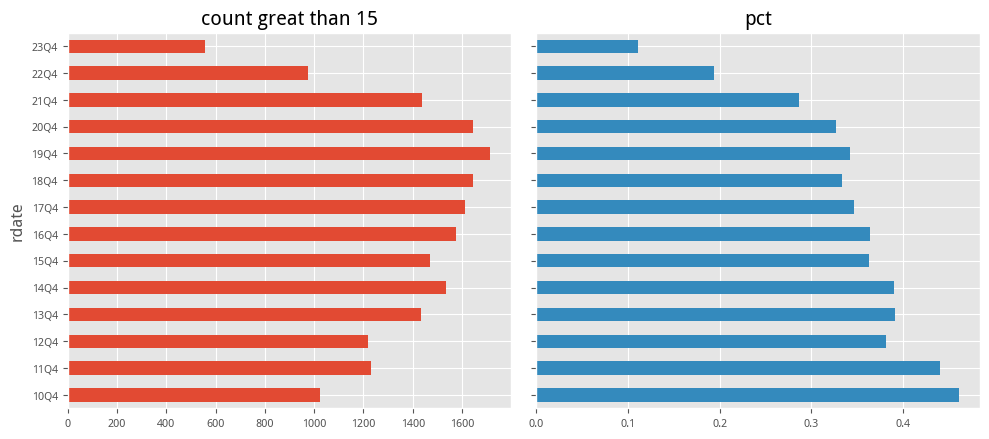

In [17]:
yjbb.gt_per_year(roe_df)

- 数量和占比都在减少。2023年只有12%的公司ROE超过15%。

## 增长情况
- 选择了有6期以上报告的公司，测试其近5年利润增长的夏普指数平均值，从高到低排列。

In [18]:
incdf, sharpe = yjbb.incr_ana(roe_df)

### 总体情况

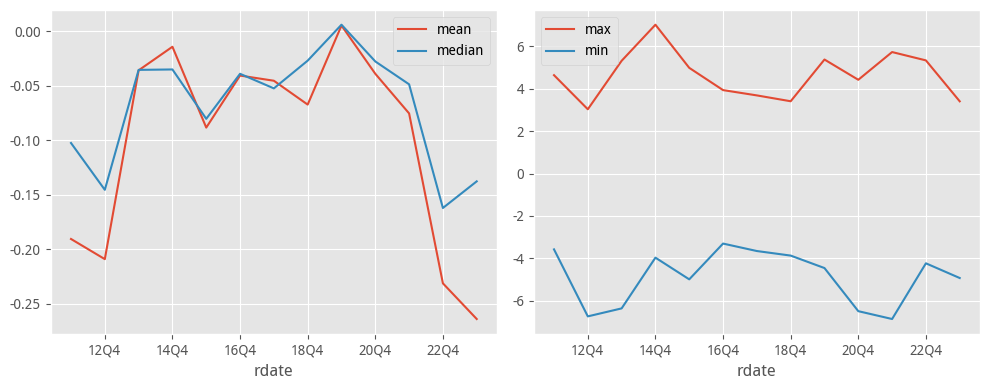

In [19]:
plot_desc(incdf)

- 增长下滑。均值和中位数都创历史新低。
- 极值缩小。

### 增长排名

In [20]:
inc300 = yjbb.get_mostn(incdf, 300)
inc300[1].head(20)

,hits,total,pct
华虹公司,3,4,0.750000
硅烷科技,5,8,0.625000
安培龙,3,5,0.600000
尚太科技,3,5,0.600000
川宁生物,3,5,0.600000
圣湘生物,3,5,0.600000
晶科能源,3,5,0.600000
儒竞科技,3,5,0.600000
华鑫股份,7,13,0.538462
九鼎投资,7,13,0.538462


- ROE增长速度较快的，看来没有很多熟悉的公司。

### 最近一年增长情况

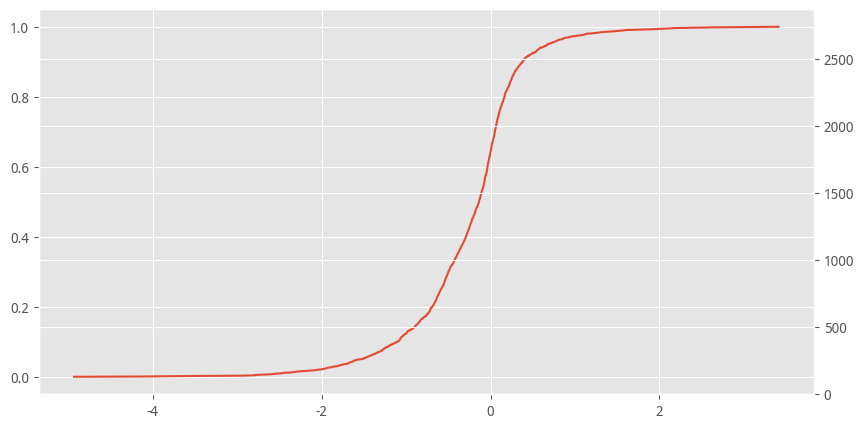

In [21]:
plot_cdf(incdf)

- 超过6成的公司ROE没有增长。

### 夏普指数
- 夏普指数衡量增长的质量，比单纯看增长率要好一点。
- 以下是近五年夏普指数平均后的前300排名。

In [22]:
sharpe300 = sharpe['sharpe_r5'].head(300)

In [23]:
yjbb.fold_a_col(sharpe300)

total: 300


,1,2,3,4,5,6,7,8,9,10
0,硅烷科技 1.23,无锡鼎邦 1.06,海昇药业 0.94,松井股份 0.76,普门科技 0.74,三元生物 0.71,斯达半导 0.67,伟星新材 0.62,新天绿能 0.62,振华科技 0.61
1,航天电器 0.60,天健集团 0.57,华瓷股份 0.56,键凯科技 0.52,爱尔眼科 0.52,南京高科 0.50,博亚精工 0.50,科润智控 0.49,中国国贸 0.49,祖名股份 0.48
2,捷佳伟创 0.48,一致魔芋 0.48,恒盛能源 0.47,华密新材 0.47,威胜信息 0.47,派克新材 0.46,金田股份 0.45,高铁电气 0.45,争光股份 0.45,新媒股份 0.45
3,传音控股 0.44,连城数控 0.44,顺控发展 0.43,迅安科技 0.43,中控技术 0.42,福蓉科技 0.41,盖世食品 0.41,泓禧科技 0.40,德石股份 0.40,苏州规划 0.40
4,森麒麟 0.40,天合光能 0.40,博瑞医药 0.39,中国中免 0.39,福立旺 0.39,三友医疗 0.39,吉冈精密 0.38,宝丰能源 0.38,扬农化工 0.38,众智科技 0.36
5,湖南海利 0.36,科思股份 0.35,新雷能 0.35,民士达 0.35,芭薇股份 0.34,德才股份 0.34,金博股份 0.34,远航精密 0.34,杰创智能 0.33,嘉泽新能 0.33
6,海欣股份 0.32,京新药业 0.32,金龙鱼 0.32,乐鑫科技 0.32,图南股份 0.32,新强联 0.32,迈为股份 0.31,伟明环保 0.31,鸿智科技 0.30,驰诚股份 0.30
7,佳禾智能 0.30,晶科科技 0.29,新风光 0.29,征和工业 0.29,久立特材 0.29,行动教育 0.29,百胜智能 0.28,天元智能 0.28,芯源微 0.28,同济科技 0.28
8,华金资本 0.28,长龄液压 0.27,洪城环境 0.27,联环药业 0.27,八亿时空 0.27,奇正藏药 0.27,汇通能源 0.27,华翔股份 0.26,普洛药业 0.26,科安达 0.26
9,合盛硅业 0.26,贝特瑞 0.26,福能股份 0.26,洪通燃气 0.26,新奥股份 0.26,邦德股份 0.26,天能股份 0.26,元道通信 0.26,安德利 0.26,平高电气 0.26


## 金额和增长
- ROE曾经进入过前300,同时夏普指数近五年平均也进入前300。

In [24]:
both_df = cross_dfs(sharpe300.reset_index(), [top300[1].reset_index(names='cname')])[['cname', 'sharpe_r5']]
yjbb.fold_a_col(both_df.set_index('cname').iloc[:,0])

total: 115


,1,2,3,4,5,6,7,8,9,10
0,硅烷科技 1.23,无锡鼎邦 1.06,海昇药业 0.94,普门科技 0.74,三元生物 0.71,伟星新材 0.62,振华科技 0.61,捷佳伟创 0.48,恒盛能源 0.47,威胜信息 0.47
1,新媒股份 0.45,争光股份 0.45,传音控股 0.44,连城数控 0.44,迅安科技 0.43,盖世食品 0.41,天合光能 0.40,中国中免 0.39,吉冈精密 0.38,众智科技 0.36
2,科思股份 0.35,芭薇股份 0.34,金博股份 0.34,乐鑫科技 0.32,图南股份 0.32,新强联 0.32,伟明环保 0.31,迈为股份 0.31,鸿智科技 0.30,久立特材 0.29
3,行动教育 0.29,天元智能 0.28,长龄液压 0.27,合盛硅业 0.26,贝特瑞 0.26,天能股份 0.26,邦德股份 0.26,新奥股份 0.26,蓝特光学 0.25,璞泰来 0.25
4,美瑞新材 0.25,华维设计 0.25,智洋创新 0.25,济川药业 0.24,密封科技 0.24,东方碳素 0.24,景津装备 0.23,万胜智能 0.23,利仁科技 0.22,百洋医药 0.22
5,锋尚文化 0.21,冠农股份 0.21,浩欧博 0.21,开普云 0.21,迈瑞医疗 0.21,英科医疗 0.20,雅葆轩 0.20,易点天下 0.19,德业股份 0.19,紫光国微 0.18
6,新芝生物 0.18,健民集团 0.18,恒立钻具 0.17,视觉中国 0.17,青矩技术 0.17,利通科技 0.17,羚锐制药 0.17,华鲁恒升 0.17,斯菱股份 0.17,海澜之家 0.16
7,通易航天 0.16,新亚强 0.16,优宁维 0.15,利尔化学 0.15,华峰铝业 0.15,广弘控股 0.15,四川路桥 0.14,恒进感应 0.14,美硕科技 0.14,建业股份 0.14
8,中科美菱 0.14,长春高新 0.14,博俊科技 0.14,同兴环保 0.14,博迅生物 0.14,立讯精密 0.14,瑞奇智造 0.14,瑞茂通 0.14,协昌科技 0.13,宝武镁业 0.13
9,吉比特 0.13,科源制药 0.13,海天精工 0.13,九鼎投资 0.13,德瑞锂电 0.13,艾融软件 0.12,金力永磁 0.12,昊帆生物 0.12,同花顺 0.12,舍得酒业 0.11


In [25]:
de_banks(both_df)

total: 115 | banks: 0 | non-banks: 115


,cname,sharpe_r5
0,硅烷科技,1.23
1,无锡鼎邦,1.06
2,海昇药业,0.94
4,普门科技,0.74
5,三元生物,0.71
...,...,...
285,创识科技,0.10
288,海利尔,0.09
289,伯特利,0.09
290,浙商中拓,0.09


- ROE高，同时ROE平均增长还高的，果然没有任何大金融。

In [26]:
import nbformat as nbf
from pathlib import Path
def remove_input():
    fn = Path('05_yjbb_roe.ipynb')
    nb = nbf.read(fn, nbf.NO_CONVERT)
    for cell in nb.cells:
        cell_tags = cell.get('metadata', {}).get('tags', [])
        if not 'remove_input' in cell_tags:
            cell_tags.append('remove_input')
            cell['metadata']['tags'] = cell_tags
    nbf.write(nb, fn)
remove_input()